# Linear variational quantum classifier

In the first example we will create a linear quantum classifier. The data is input to the model as a quantum state. The variational part will look for the optimal measurement to distinguish among classes.  

In [48]:

import numpy as np
import pickle
from qclassifier_solutions import QuantumClassifer, single_qubit_classifier


In [49]:
# Specify problem parameters

nqubits = 4
nlayers = 5
nclasses=3
RY = True
nshots = int(1e4)
method = 'Powell'

In [50]:
# We load the iris dataset to classify

path_data = "iris.data"
data = open(path_data)
data = data.readlines()
data = [i.split(",") for i in data]

for i in range(len(data)):
    del data[i][-1]  # We delete text labels from the kets
    data[i] += [0] * (2**nqubits - 4)  # We pad with zeros
    data[i] = np.float32(data[i])  # We transform strings to floats
    # We re-scale each feature of the data
    data[i][0] /= 7.9
    data[i][1] /= 4.4
    data[i][2] /= 6.9
    data[i][3] /= 2.5
    data[i] = data[i] ** 2
    data[i] /= np.linalg.norm(data[i])  # We normalize the ket

    # This ket will be the input state to our model

data = np.float32(np.array(data))

# We define our training set (both kets and labels)
data_train = np.concatenate((data[0:35], data[50:85], data[100:135]))
labels_train = np.array([[1, 1]] * 35 + [[1, -1]] * 35 + [[-1, 1]] * 35)

# We define our test set (both kets and labels)
data_test = np.concatenate((data[35:50], data[85:100], data[135:150]))
labels_test = [[1, 1]] * 15 + [[1, -1]] * 15 + [[-1, 1]] * 15


In [38]:
# We can now create the quantum circuit to classify our data

qc = QuantumClassifer(nclasses, nqubits, nlayers, RY=RY)

print(qc._circuit.draw(1000))

# 4 qubits and 3 layers, RY = True is pre-trained

q0: ─RY─o───RY───o─RY─o───RY───o─RY─o───RY───o─RY─o───RY───o─RY─o───RY───o─RY─M─
q1: ─RY─Z───RY─o─|─RY─Z───RY─o─|─RY─Z───RY─o─|─RY─Z───RY─o─|─RY─Z───RY─o─|─RY─M─
q2: ─RY───o─RY─Z─|─RY───o─RY─Z─|─RY───o─RY─Z─|─RY───o─RY─Z─|─RY───o─RY─Z─|─RY───
q3: ─RY───Z─RY───Z─RY───Z─RY───Z─RY───Z─RY───Z─RY───Z─RY───Z─RY───Z─RY───Z─RY───


In [39]:
# Training

if RY:
    try:
        path_angles = ( f"optimal_angles_ry_{nqubits}q_{nlayers}l.npy"
        )
        optimal_angles = np.load(path_angles)
    except:
        print(
            "There are no pre-trained angles saved for this choice of nqubits, nlayers and type of ansatz."
        )
        measured_qubits = int(np.ceil(np.log2(nclasses)))
        initial_parameters = (
            2
            * np.pi
            * np.random.rand(2 * nqubits * nlayers + nqubits + measured_qubits)
        )
        for bias in range(measured_qubits):
            initial_parameters[bias] = 0.0
        print("Training classifier...")
        cost_function, optimal_angles = qc.minimize(
            initial_parameters,
            data_train,
            labels_train,
            nshots=nshots,
            method=method,
        )
        path_angles = (
            f"optimal_angles_ry_{nqubits}q_{nlayers}l.npy"
        )
        np.save(
            path_angles,
            optimal_angles,
        )
else:
    try:
        path_angles = ( f"optimal_angles_rxrzrx_{nqubits}q_{nlayers}l.npy"
        )
        optimal_angles = np.load(path_angles)
    except:
        print(
            "There are no pre-trained angles saved for this choice of nqubits, nlayers and type of ansatz."
        )
        measured_qubits = int(np.ceil(np.log2(nclasses)))
        initial_parameters = (
                2
                * np.pi
                * np.random.rand(6 * nqubits * nlayers + 3 * nqubits + measured_qubits)
            )
        for bias in range(measured_qubits):
            initial_parameters[bias] = 0.0
        print("Training classifier...")
        cost_function, optimal_angles = qc.minimize(
            initial_parameters,
            data_train,
            labels_train,
            nshots=nshots,
            method=method,
        )
        path_angles = (f"optimal_angles_rxrzrx_{nqubits}q_{nlayers}l.npy"
        )
        np.save(
            path_angles,
            optimal_angles,
        )

In [40]:
# We test our model

# We run an accuracy check for the training and the test sets
predictions_train = [
    qc.Predictions(
        qc.Classifier_circuit(optimal_angles),
        optimal_angles,
        init_state=ket,
        nshots=nshots,
    )
    for ket in data_train
]
predictions_test = [
    qc.Predictions(
        qc.Classifier_circuit(optimal_angles),
        optimal_angles,
        init_state=ket,
        nshots=nshots,
    )
    for ket in data_test
]

print(
    f"Train set | # Clases: {nclasses} | # Qubits: {nqubits} | # Layers: {nlayers} | "
    + f"Accuracy: {qc.Accuracy(labels_train, predictions_train)}"
)
print(
    f"Test set  | # Clases: {nclasses} | # Qubits: {nqubits} | # Layers: {nlayers} | "
    + f"Accuracy: {qc.Accuracy(labels_test, predictions_test)}"
)


Train set | # Clases: 3 | # Qubits: 4 | # Layers: 5 | Accuracy: 0.638095238095238
Test set  | # Clases: 3 | # Qubits: 4 | # Layers: 5 | Accuracy: 0.6888888888888889


# Re-uploading classifiers

For the second example, we will use a re-uploading classifier to classify synthetic data based on geometry

In [67]:
dataset = '3_circles'
layers = 3

In [ ]:
ql = single_qubit_classifier(dataset, layers)  # Define classifier
try:
    with open("saved_parameters.pkl", "rb") as f:
        # Load previous results. Have we ever run these problem?
        data = pickle.load(f)
except:
    data = {dataset: {}}

try:
    parameters = data[dataset][layers]
    print("Problem solved before, obtaining parameters from file...")
    print("-" * 60)
except:
    print("Problem never solved, finding optimal parameters...")
    result, parameters = ql.minimize(method="l-bfgs-b", options={"disp": True})

    if dataset not in data.keys(): 
        data[dataset] = {} 
    data[dataset][layers] = parameters
    with open("saved_parameters.pkl", "wb") as f:
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

{'tricrown': {5: array([ 1.78801189,  1.47179716,  0.0147476 , -1.4242464 , -2.21694652,
        1.33103362, -2.90385909,  1.68074996,  0.91113526,  1.41821972,
       -2.08805568,  0.2010839 ,  0.93171895, -2.92382856,  0.82344727,
       -1.25773858,  2.51701928, -0.88745202, -0.06344318,  1.74243439])}, '3_circles': {2: array([ 0.43573639,  0.62908229, -2.63844704, -0.03161139,  1.53078984,
       -0.05227542,  1.10994618,  2.13194792]), 1: array([ 0.07232168,  1.14616749, -1.86839194,  2.07398703])}}
Problem never solved, finding optimal parameters...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.86702D-01    |proj g|=  6.18774D-02


 This problem is unconstrained.



At iterate    1    f=  1.13495D-01    |proj g|=  4.60468D-02

At iterate    2    f=  8.59660D-02    |proj g|=  2.86171D-02

At iterate    3    f=  7.50883D-02    |proj g|=  1.55341D-02

At iterate    4    f=  6.76729D-02    |proj g|=  1.95095D-02

At iterate    5    f=  5.93972D-02    |proj g|=  1.76448D-02

At iterate    6    f=  5.19018D-02    |proj g|=  1.10206D-02

At iterate    7    f=  4.87521D-02    |proj g|=  1.53813D-02

At iterate    8    f=  4.33771D-02    |proj g|=  1.95525D-02

At iterate    9    f=  3.80449D-02    |proj g|=  1.65574D-02

At iterate   10    f=  3.34927D-02    |proj g|=  1.05156D-02

At iterate   11    f=  3.22593D-02    |proj g|=  3.63190D-03

At iterate   12    f=  3.19875D-02    |proj g|=  3.12849D-03

At iterate   13    f=  3.16873D-02    |proj g|=  2.16725D-03

At iterate   14    f=  3.11897D-02    |proj g|=  4.04946D-03

At iterate   15    f=  3.03953D-02    |proj g|=  5.99984D-03

At iterate   16    f=  3.00900D-02    |proj g|=  6.83760D-03

At iter

The value of the cost function achieved is 0.015610
The accuracy for this classification is 76.40 %


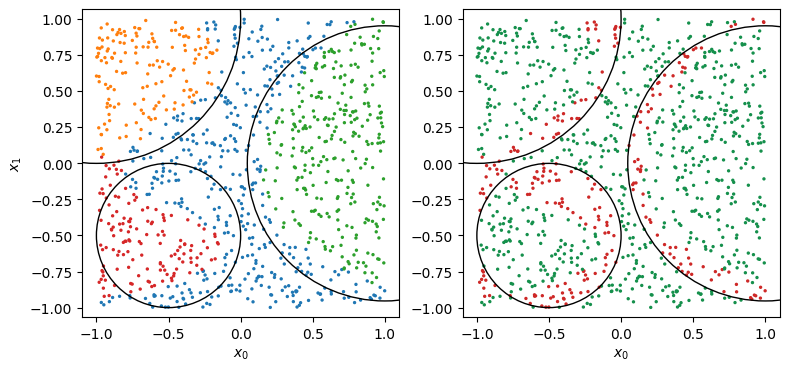

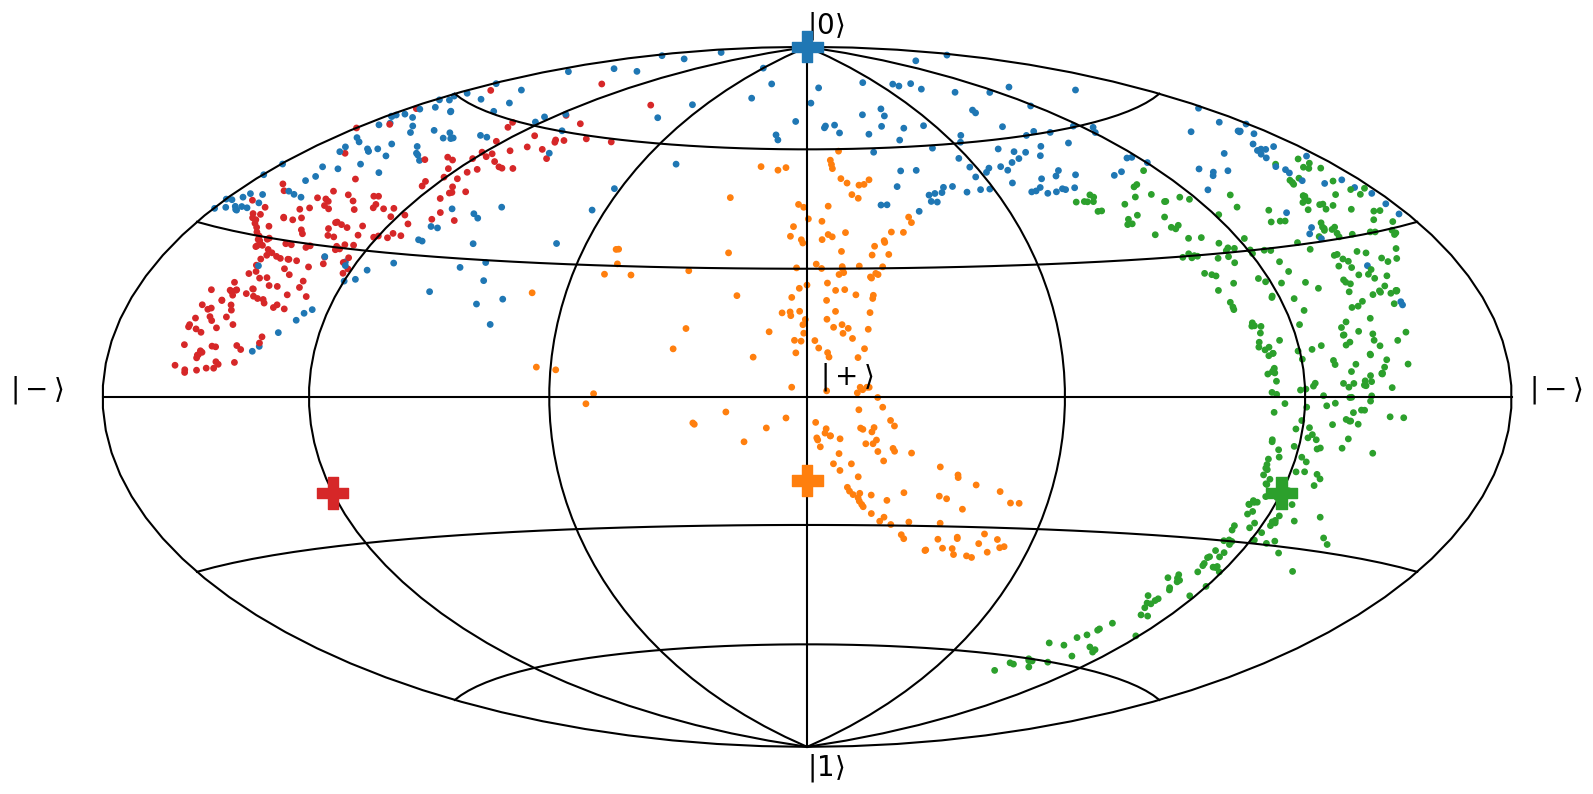

In [69]:

ql.set_parameters(parameters)
value_loss = ql.cost_function_fidelity()
print("The value of the cost function achieved is %.6f" % value_loss)
ql.paint_results()
ql.paint_world_map()